# Extract data from RADKLIM / RADOLAN for given locations: Berlin example

In [2]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
#import netCDF4 as nc
import scipy.spatial as sp
import wradlib.georef as georef
import wradlib
import datetime as dt
import xarray as xr
import rasterio
import rasterio.mask as riom
import tarfile
import sys
import glob
import xarray as xr
import tarfile

## Import locations (here: point coordinates)

In [74]:
# Catchments
locs = gpd.read_file("data/berlin/Gebiete_Inno_MAUS_region.shp")
locs = locs.to_crs("EPSG:4326")
# Coordinates: catchment centroids (for larger catchments, we'd have to do )
xy = np.array([locs.centroid.geometry.x, locs.centroid.geometry.y]).T#.to_crs("EPSG:32632")
xy

/tmp/ipykernel_75472/3768025905.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  xy = np.array([locs.centroid.geometry.x, locs.centroid.geometry.y]).T#.to_crs("EPSG:32632")
/tmp/ipykernel_75472/3768025905.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  xy = np.array([locs.centroid.geometry.x, locs.centroid.geometry.y]).T#.to_crs("EPSG:32632")


array([[13.37997173, 52.51206733],
       [13.42966704, 52.50049927],
       [13.40112851, 52.49415395]])

## RADOLAN coordinates for RADKLIM grid

In [187]:
radolan_grid_ll = georef.get_radolan_grid(1100,900, wgs84=True)
#print("{0}, ({1:.4f}, {2:.4f})".format(radolan_grid_ll.shape, *radolan_grid_ll[0,0,:]))

lons = radolan_grid_ll[:,:,0].ravel()
lats = radolan_grid_ll[:,:,1].ravel()
tree = sp.KDTree(np.c_[lons, lats])
dd, ii = tree.query(xy, k=1)
# These are the unique RADOLN pixel coordinates that are clostest to the target points
# (unique, because one RADOLAN pixel could be closest to several target pixels)
ids = np.unique(ii)

/home/maik/miniconda3/envs/cs2/lib/python3.9/site-packages/wradlib/georef/projection.py:172: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(gdal.VersionInfo("RELEASE_NAME")) >= LooseVersion("3"):
/home/maik/miniconda3/envs/cs2/lib/python3.9/site-packages/wradlib/georef/projection.py:172: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(gdal.VersionInfo("RELEASE_NAME")) >= LooseVersion("3"):
/home/maik/miniconda3/envs/cs2/lib/python3.9/site-packages/wradlib/georef/projection.py:304: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(gdal.VersionInfo("RELEASE_NAME")) >= LooseVersion("3"):
/home/maik/miniconda3/envs/cs2/lib/python3.9/site-packages/wradlib/georef/projection.py:304: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(gdal.VersionInfo

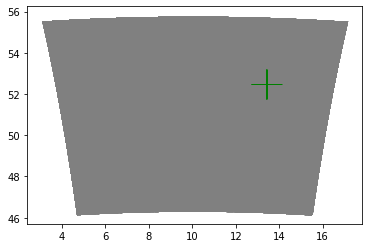

In [30]:
# Check spatial constellation
fig, ax = plt.subplots(1,1)
plt.plot(lons, lats, marker="+", lw=0, color="grey", ms=1)
plt.plot(lons[ids], lats[ids], "g+", ms=30)

## Read RADKLIM data from 2001 to 2021 (as downloaded from opendata)

Download code:

`wget -r -np -nd -nc -A "*tar.gz" -R "*latest*" https://opendata.dwd.de/climate_environment/CDC/grids_germany/hourly/radolan/reproc/2017_002/bin/`


In [31]:
#tarfs = glob.glob("data/rw/2021_repr/RW2017.002_*.tar.gz")
tarfs = glob.glob("data/rw/radklim-rw/RW2017.002_*.tar.gz")
tarfs.sort()
df = pd.DataFrame(columns=ids)
for tarf in tarfs:
    print(tarf)
    tar = tarfile.open(tarf)
    members = tar.getmembers()
    dtimes = []
    alldata = np.zeros((len(members),len(ids)))
    for i,member in enumerate(members):
        f=tar.extractfile(member)
        data, metadata = wradlib.io.read_radolan_composite(f)
        data[data==-9999.] = np.nan
        dtimes.append( metadata["datetime"] )
        alldata[i,:] = data.ravel()[ids]              
    tar.close()
    tmp = pd.DataFrame(alldata, columns=ids, index=dtimes)
    df = pd.concat( [df, tmp] )
df = df.sort_index()

data/rw/radklim-rw/RW2017.002_200101.tar.gz
data/rw/radklim-rw/RW2017.002_200102.tar.gz
data/rw/radklim-rw/RW2017.002_200103.tar.gz
data/rw/radklim-rw/RW2017.002_200104.tar.gz
data/rw/radklim-rw/RW2017.002_200105.tar.gz
data/rw/radklim-rw/RW2017.002_200106.tar.gz
data/rw/radklim-rw/RW2017.002_200107.tar.gz
data/rw/radklim-rw/RW2017.002_200108.tar.gz
data/rw/radklim-rw/RW2017.002_200109.tar.gz
data/rw/radklim-rw/RW2017.002_200110.tar.gz
data/rw/radklim-rw/RW2017.002_200111.tar.gz
data/rw/radklim-rw/RW2017.002_200112.tar.gz
data/rw/radklim-rw/RW2017.002_200201.tar.gz
data/rw/radklim-rw/RW2017.002_200202.tar.gz
data/rw/radklim-rw/RW2017.002_200203.tar.gz
data/rw/radklim-rw/RW2017.002_200204.tar.gz
data/rw/radklim-rw/RW2017.002_200205.tar.gz
data/rw/radklim-rw/RW2017.002_200206.tar.gz
data/rw/radklim-rw/RW2017.002_200207.tar.gz
data/rw/radklim-rw/RW2017.002_200208.tar.gz
data/rw/radklim-rw/RW2017.002_200209.tar.gz
data/rw/radklim-rw/RW2017.002_200210.tar.gz
data/rw/radklim-rw/RW2017.002_20

data/rw/radklim-rw/RW2017.002_201608.tar.gz
data/rw/radklim-rw/RW2017.002_201609.tar.gz
data/rw/radklim-rw/RW2017.002_201610.tar.gz
data/rw/radklim-rw/RW2017.002_201611.tar.gz
data/rw/radklim-rw/RW2017.002_201612.tar.gz
data/rw/radklim-rw/RW2017.002_201701.tar.gz
data/rw/radklim-rw/RW2017.002_201702.tar.gz
data/rw/radklim-rw/RW2017.002_201703.tar.gz
data/rw/radklim-rw/RW2017.002_201704.tar.gz
data/rw/radklim-rw/RW2017.002_201705.tar.gz
data/rw/radklim-rw/RW2017.002_201706.tar.gz
data/rw/radklim-rw/RW2017.002_201707.tar.gz
data/rw/radklim-rw/RW2017.002_201708.tar.gz
data/rw/radklim-rw/RW2017.002_201709.tar.gz
data/rw/radklim-rw/RW2017.002_201710.tar.gz
data/rw/radklim-rw/RW2017.002_201711.tar.gz
data/rw/radklim-rw/RW2017.002_201712.tar.gz
data/rw/radklim-rw/RW2017.002_201801.tar.gz
data/rw/radklim-rw/RW2017.002_201802.tar.gz
data/rw/radklim-rw/RW2017.002_201803.tar.gz
data/rw/radklim-rw/RW2017.002_201804.tar.gz
data/rw/radklim-rw/RW2017.002_201805.tar.gz
data/rw/radklim-rw/RW2017.002_20

In [35]:
df.columns = ["berlin3", "berlin1", "berlin2"]

## Save results as csv

In [36]:
header="""# This file contains the hourly precipitation time series for each RADOLAN pixel ID.
# The RADOLAN pixel IDs are used as column headers and are mapped to each rover grid point in the file
# rover2radolan.csv. The locations of the RADOLAN pixel are also redundantly specified in the file 
# radolan-coords.csv. Datetime is in UTC and refers to the end of an hourly interval.
"""
with open("data/locs/radolan-extract-berlin.csv", "w") as f:
    f.write(header)
    df.to_csv(f, index=True, date_format="%Y-%m-%dT%H:%M:%S", 
              index_label="datetime", float_format="%.2f")

In [37]:
header="""# This file contains the locations (pixel center coordinates) of the RADOLAN pixels.
# 
# pixelid: ID of radolan pixel mapped to rover grid points (see also rover2radolan.csv and radolan-extract.csv)
# lon: longitude of radolan pixel (EPSG:4326)
# lat: latitude of radolan pixel (EPSG:4326)
"""
with open("data/locs/radolan-coords-berlin.csv", "w") as f:
    f.write(header)
    dfpixels = pd.DataFrame(np.c_[lons[ids], lats[ids]], index=df.columns, columns=["lon", "lat"] )
    dfpixels.to_csv(f, index=True, index_label="pixel_id", float_format="%.6f")

## Analysis: find dates with 6h-accumulations exceeding warning level III 

In [59]:
dfacc = df.resample("6H", label="right").sum()
dfacc[np.any(dfacc>35, axis=1)]

,berlin3,berlin1,berlin2
2003-09-25 06:00:00,39.8,39.5,21.0
2003-09-29 06:00:00,15.6,39.5,16.4
2003-09-29 12:00:00,23.8,35.4,16.4
2003-09-30 00:00:00,13.1,35.2,16.8
2003-09-30 06:00:00,16.4,41.3,20.6
2007-08-24 06:00:00,37.1,31.9,20.8
2017-06-29 18:00:00,45.8,36.6,52.5
2019-06-12 00:00:00,52.0,36.6,33.1
2019-08-02 18:00:00,39.6,28.7,45.8


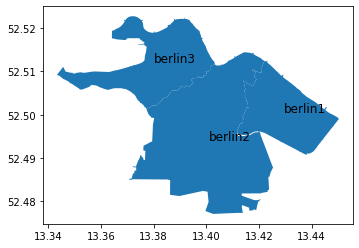

In [58]:
fig, ax = plt.subplots(1,1)
locs.plot(ax=ax)
for i, xy_ in enumerate(xy):
    plt.text(xy_[0], xy_[1], df.columns[i], fontsize=12)

In [60]:
sel = dfacc[np.any(dfacc>35, axis=1)]

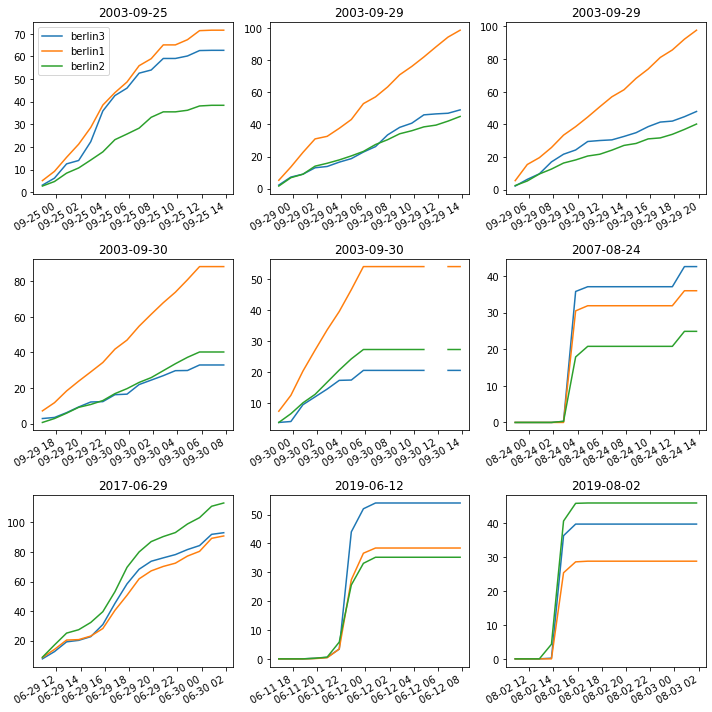

In [73]:
fig, ax = plt.subplots(3,3, figsize=(10,10))
ax = ax.ravel()
tdelta = dt.timedelta(seconds=3600*8)

for i,j in enumerate(sel.index):
    tmp = df.loc[j-tdelta:j+tdelta].cumsum()
    legend = False
    if i==0:
        legend=True
    tmp.plot(ax=ax[i], title=j.strftime("%Y-%m-%d"), legend=legend)

plt.tight_layout()
plt.savefig("berlin_events.png", dpi=300, facecolor="white")

<AxesSubplot:>

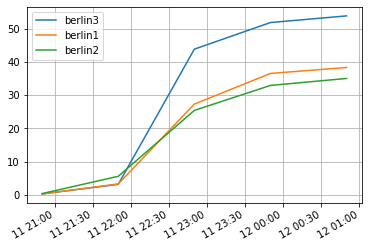

In [164]:
fig, ax = plt.subplots(1,1, figsize=(6,4))
df.loc["2019-06-11 20:00:00":"2019-06-12 01:00:00"].cumsum().plot(ax=ax, grid=True)

In [123]:
berlin = gpd.read_file("data/berlin/RBS_OD_ORT_1412.shp")
berlinw = gpd.read_file("/media/x/data/OSM/berlin/gis_osm_waterways_free_1.shp").to_crs("EPSG:4326")

In [184]:
acctimes = pd.date_range("2019-06-11 21:50:00", "2019-06-12 01:50:00", freq="60T")
#binfiles = ["raa01-rw2017.002_10000-%y%m%d%H%M-dwd---bin" for acctime in acctimes]
tar = tarfile.open("data/rw/radklim-rw/RW2017.002_201906.tar.gz")
#members = tar.getmembers()
#dtimes = []
alldata = np.zeros((len(acctimes),1100,900))
for i,acctime in enumerate(acctimes):
    member = acctime.strftime("raa01-rw2017.002_10000-%y%m%d%H%M-dwd---bin") 
    f=tar.extractfile(member)
    data, metadata = wradlib.io.read_radolan_composite(f)
    data[data==-9999.] = np.nan
    alldata[i] = data
tar.close()

/tmp/ipykernel_75472/2930903118.py:6: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  cp = plt.pcolormesh(radolan_grid_ll[:,:,0], radolan_grid_ll[:,:,1], alldata.sum(axis=0), cmap=plt.cm.nipy_spectral, vmax=60)


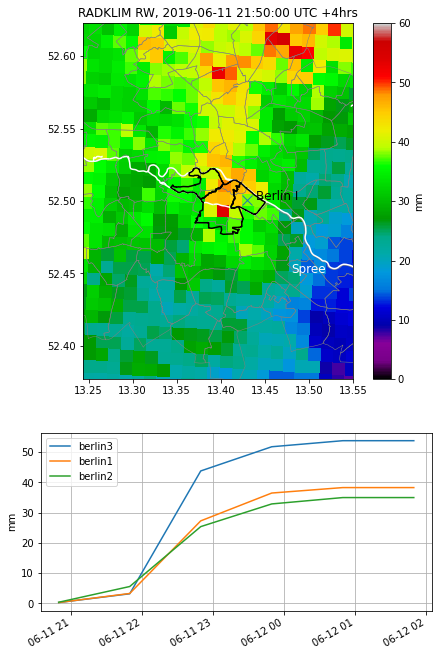

In [186]:
fig, ax = plt.subplots(2,1, figsize=(7,12), gridspec_kw= {"height_ratios":[2,1]})

plt.sca(ax[0])
xlim = locs.to_crs("EPSG:4326").total_bounds[np.array([0,2])] + np.array([-0.1, 0.1])
ylim = locs.to_crs("EPSG:4326").total_bounds[np.array([1,3])] + np.array([-0.1, 0.1])
cp = plt.pcolormesh(radolan_grid_ll[:,:,0], radolan_grid_ll[:,:,1], alldata.sum(axis=0), cmap=plt.cm.nipy_spectral, vmax=60)
plt.colorbar(cp, label="mm")

berlin.to_crs("EPSG:4326").plot(ax=ax[0], fc="None", ec="grey", lw=0.5)
berlinw[berlinw.fclass=="river"].plot(ax=ax[0], color="white")
berlinw[berlinw.name=="Landwehrkanal"].plot(ax=ax[0], color="white")
locs.to_crs("EPSG:4326").plot(ax=ax[0], fc="None", ec="black", lw=1.5, zorder=10)

#locs.loc[[1]].to_crs("EPSG:4326").plot(ax=ax, fc="white", ec="None", alpha=0.6)
plt.text(xy[1,0]+0.01, xy[1,1], "Berlin I", fontsize=12)
plt.plot(xy[1,0], xy[1,1], marker="x", ms=10)
plt.text(xy[1,0]+0.05, xy[1,1]-0.05, "Spree", fontsize=12, color="white")
plt.xlim(xlim)
plt.ylim(ylim)
plt.title("RADKLIM RW, 2019-06-11 21:50:00 UTC +4hrs")

plt.sca(ax[1])
df.loc["2019-06-11 20:00:00":"2019-06-12 01:50:00"].cumsum().plot(ax=ax[1], grid=True, ylabel="mm")

plt.savefig("berlin_2019-06-11_event.png", dpi=600, facecolor="white")

In [140]:
berlinw

,osm_id,code,fclass,width,name,geometry
0,4041237,8103,canal,0,Landwehrkanal,"LINESTRING (13.45161 52.49967, 13.45067 52.498..."
1,4446691,8101,river,0,Spree,"LINESTRING (13.67624 52.43323, 13.67613 52.433..."
2,4450826,8103,canal,0,Westhafenkanal,"LINESTRING (13.33046 52.53851, 13.32952 52.538..."
3,4450828,8103,canal,0,Berlin-Spandauer Schifffahrtskanal,"LINESTRING (13.32564 52.54181, 13.32620 52.541..."
4,4463192,8103,canal,0,Zehlendorfer Stichkanal,"LINESTRING (13.28570 52.41402, 13.28288 52.412..."
...,...,...,...,...,...,...
1959,620093183,8102,stream,0,None,"LINESTRING (13.30228 52.45543, 13.30229 52.455..."
1960,623464297,8104,drain,0,None,"LINESTRING (13.47974 52.63541, 13.47742 52.63528)"
1961,623464298,8104,drain,0,None,"LINESTRING (13.47987 52.63542, 13.47974 52.63541)"
1962,623464300,8104,drain,0,None,"LINESTRING (13.47974 52.63580, 13.47906 52.635..."
